<a href="https://colab.research.google.com/github/ericbfeng/chess_piece_recognitions/blob/main/chessPieceIdentification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Finished



































New Model









In [ ]:
from google.colab import drive
drive.mount('/content/drive')

data_dir = '/content/drive/MyDrive/CS221-final-data'

!pip install split-folders
import splitfolders  # or import split_folders


Mounted at /content/drive


In [ ]:
#Preprocess the data:






















In [ ]:
# Split with a ratio.
#/content/drive/MyDrive/output/
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio( data_dir, output="content/drive/MyDrive/output/Images", seed=1337, ratio=(.7, .3), group_prefix=None) # default values



Copying files: 0 files [00:00, ? files/s]


All changes made in this colab session should now be visible in Drive.


In [ ]:
import numpy as np
import os
import torch
import torch.nn as nn
from torchvision import transforms,models,datasets
from torch.utils.data import Dataset, DataLoader
import math
from PIL import Image
from torchsummary import summary
from numpy import asarray
import torch.optim as optim
import time
import os
import copy

model = models.resnet18(pretrained= True)
#model.eval


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:

batch_size = 8
data_dir = "/content/drive/MyDrive/output/Images"
save_dir = "/content/drive/MyDrive/Model"
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),

}
    



print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}
print(dataloaders_dict)
""" "cuda:0" if torch.cuda.is_available() else """
device = torch.device( "cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7fc7ea555f10>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7fc7ea549790>}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
for param in model.parameters():
    param.requires_grad = False
    
NUM_PIECES = 13
num_epochs = 50
losses = {'train':[], 'val':[]}
accuracies = {'train':[], 'val':[]}
model.fc = nn.Sequential(nn.Linear(512, NUM_PIECES) , nn.LogSoftmax(dim=1))

#model.eval


In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            accuracies[phase].append(epoch_acc)
            losses[phase].append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc.item())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    print(val_acc_history)


    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [ ]:
model = model.to(device)
criterion = nn.CrossEntropyLoss()
print(device)

params_to_update = model.parameters()
print("Params to learn:")
params_to_update = []
for name,param in model.named_parameters():
  if param.requires_grad == True:
    params_to_update.append(param)
    print("\t",name)
    
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

cuda:0
Params to learn:
	 fc.0.weight
	 fc.0.bias


In [ ]:
print(device)
model_ft, hist = train_model(model, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)
torch.save(model_ft.state_dict(), save_dir)

NameError: ignored

In [ ]:
torch.save(model_ft.state_dict(), save_dir)
print("saved ")
print(losses["train"])

NameError: ignored

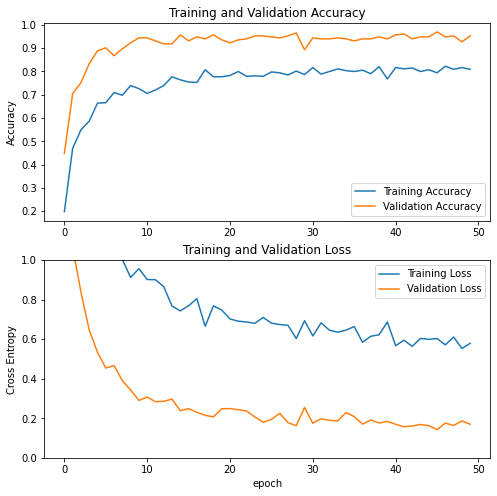

In [ ]:

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.image import imread

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(accuracies['train'], label='Training Accuracy')
plt.plot(accuracies['val'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(losses['train'], label='Training Loss')
plt.plot(losses['val'], label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()








In [ ]:

#ONLY RUN IF LOADING
model_ft = models.resnet18(pretrained= True)
model_ft.fc = nn.Sequential(nn.Linear(512, NUM_PIECES) , nn.LogSoftmax(dim=1))
model_ft.load_state_dict(torch.load(save_dir))


In [ ]:
#Run new data

running_corrects = 0
model_ft.to(device)
model_ft.eval()
final = [] 

for inputs, labels in dataloaders_dict["train"]:
  #print(inputs.shape)
  inputs = inputs.to(device)
  print(inputs.shape)
  labels = labels.to(device)
  with torch.no_grad():
    outputs = model_ft(inputs)
    print(outputs.shape)
    _, preds = torch.max(outputs, 1)
    running_corrects += torch.sum(preds == labels.data)
    print(labels.data)
    final += preds.tolist()
print(final)




/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([8, 3, 224, 224])
torch.Size([8, 13])
tensor([ 5,  2,  5,  4,  7,  0, 11,  9], device='cuda:0')
torch.Size([8, 3, 224, 224])
torch.Size([8, 13])
tensor([ 5, 10,  0,  3,  7,  7, 11,  7], device='cuda:0')
torch.Size([8, 3, 224, 224])
torch.Size([8, 13])
tensor([7, 4, 5, 1, 7, 4, 8, 8], device='cuda:0')
torch.Size([8, 3, 224, 224])
torch.Size([8, 13])
tensor([2, 4, 1, 5, 8, 9, 8, 5], device='cuda:0')
torch.Size([8, 3, 224, 224])
torch.Size([8, 13])
tensor([ 8,  6, 10,  4,  5,  2,  2,  0], device='cuda:0')
torch.Size([8, 3, 224, 224])
torch.Size([8, 13])
tensor([11,  1,  6,  3,  0,  0, 12, 11], device='cuda:0')


KeyboardInterrupt: ignored

In [ ]:
import cv2
import numpy as np

image = ""
for coord in cordinates:
  sub[(center-x):(center + x), (center-y):(center+y) , :]


In [ ]:
test = []
for i in range(19):
 test.append(6) 
test.append(7)
test.append(6)
test.append(0)
for i in range(9):
  test.append(6)
test.append(2)
test.append(9)
for i in range(3):
  test.append(6)
test.append(0)
for i in range(5):
  test.append(6)
test.append(10)
for i in range(5):
  test.append(6)
test.append(3)
for i in range(3):
  test.append(5)
test.append(3)
for i in range(11):
  test.append(6)

test = np.array(test)

print(test)



[ 6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  7  6  0  6  6
  6  6  6  6  6  6  6  2  9  6  6  6  0  6  6  6  6  6 10  6  6  6  6  6
  3  5  5  5  3  6  6  6  6  6  6  6  6  6  6  6]


In [ ]:
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image


data = np.load("/content/drive/MyDrive/decompTest/cfc306bf86176b92ffc1afbb98d7896f_jpg.rf.effd71a5dcd98ec0f24072af5f7c0a31.jpg.npy")  






FileNotFoundError: ignored

In [ ]:
from torchvision import transforms
transform_object = transforms.Compose([
      transforms.Grayscale(num_output_channels=3),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

final = []
check = []
i = 0
for i in range(len(data)):
  single = data[i]
  pil_image=Image.fromarray(np.uint8(single), "L")
  single = transform_object(pil_image)
  single = single.reshape(1, 3, 224,224)
  single = torch.cat(8*[single])
  single = single.to(device)
  #print("Single shape", single.shape)
  with torch.no_grad():
    #input
    outputs = model_ft(single)
    _, preds = torch.max(outputs, 1)
    isSame = True
    temp = torch.tensor(np.repeat(test[i], 8))
    temp.to(device)
    #print(temp)
    print(preds)
    check.append(preds[0].item())

print(sum(final) / (len(final) * 8))

print(final)
print(check)


  



NameError: ignored

In [ ]:
test = torch.zeros([2, 4], dtype=torch.int32)

test = test.reshape(-1,2,4)
new_tensor = torch.cat(3*[test])
print(test)

print(new_tensor.shape)

tensor([[[0, 0, 0, 0],
         [0, 0, 0, 0]]], dtype=torch.int32)
torch.Size([3, 2, 4])
